<a href="https://colab.research.google.com/github/ga96jul/Bachelarbeit/blob/master/EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## EM Algorithm for K-QAM Estimation of parameters
#  The code is seperated into two main functions, a K-means estimator to estimate initial parameters for our EM-Algorithm and the EM algo.
#  Added to the normal k-means algorithm we have a constraint on being equidistant.
#  Furthermore the EM algo is seperated into real and imag plane. So we dont look at the data over the 2D plane but seperately
#  By observation of the data given to us we concluded that our data must come from a 64-QAM probabalistic amplitude shaping where most of the points aare send from
#  constellation points close to center. We checked for our K numbers lower 64 which all performed worse than 64-QAM.

# load packages and data
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
#import pdb;
data = np.load('EM_data.npy')

N = data.size

In [0]:
def ask_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    
    X = np.arange(-M+1,M,2,dtype=int)
    
    X = X.reshape((1,X.size))
    X = X/np.sqrt(np.mean(X**2))
    
    return X

def qam_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    if M == 128:
        M_ask = int(np.sqrt(144))
        tmp = ask_cstll(M_ask).reshape((M_ask,1))
        tmp = tmp + 1j*tmp.T
        X = tmp.flatten()
        X = X/np.sqrt(np.mean(np.abs(X)**2))
        for i in range(16):
            idx = np.argmax(np.abs(X))
            X = np.delete(X,idx)

    else:
        M_ask = int(np.sqrt(M))
        tmp = ask_cstll(M_ask).reshape((M_ask,1))
   
        tmp = tmp + 1j*tmp.T
        X = tmp.flatten()
        X = X/np.sqrt(np.mean(np.abs(X)**2))
    
    return X

In [0]:
# k-means algorithm with only output values known
# we choose a maximum value for the k-QAM
# iteratively compute every valid M-QAM constellation to the maximum k
# we choose the k that minimizes the uncertainty
# constraint of equidistance of each point

def k_means(y,k,iter):
    # intialize k constellation points according to a M-QAM constellation
    C = qam_cstll(k)

    # scale the cstll by a constant to also get a good first initial cluster
    max_idx = 0.5*np.max(abs(y))
    C = max_idx * C

    # init paras
    N = y.size
    iter_cnt = 0
    C0 = C
    K = C0.size
    weight = 2
    s_real = np.zeros((K,), dtype = float)
    s_imag = np.zeros((K,), dtype = float)
    s_real_cnt = np.zeros((K,), dtype = float)
    s_imag_cnt = np.zeros((K,), dtype = float)
    px_cnt = np.zeros((K,), dtype = float)
    noise_cnt = np.zeros((K,), dtype = complex)
    temp_C = np.zeros((K,), dtype = complex)  
    temp_C_3D = np.zeros((K,), dtype = complex)

    
    while (iter_cnt < iter and conv_flag == 0):
        # calculate euclidian distance
        tmp = np.abs(y.reshape((N,1)) - C.reshape((1,K)))
        # assign every data point a label
        tmp_idx = np.argmin(tmp,axis=1)
        # calculate change of constellation points
        for j in range(K):
            idx = (tmp_idx == j)
            if np.sum(idx) > 0:
                temp_C[j] = np.sum(y[idx])/np.sum(idx)
                s_real[j] = temp_C[j].real/C[j].real
                s_imag[j] = temp_C[j].imag/C[j].imag
                px_cnt[j] = y[idx].size/N
                noise_cnt[j] = np.var((y[idx].real-temp_C[j].real)) + 1j* np.var((y[idx].imag-temp_C[j].imag))
                

                
        # calculate a constant the points spread out to keep equidistant constraint
        const_real = 0
        const_imag = 0
        
        for j in range(K):
            const_real = const_real + s_real[j]
            const_imag = const_imag + s_imag[j]

        
        #if const_real == 1.0 and const_imag == 1.0:
        #    conv_flag = 1
        # add some weighting because of uneven distribution -> many points will be estimated in the center -> shifts scaling closer to the center
        const_real = const_real/(np.sum(1-weight*px_cnt))
        const_imag = const_imag/(np.sum(1-weight*px_cnt))
        #pdb.set_trace()
        #constant = const_imag + 1j * const_real
        C = const_real*C.real + 1j * const_imag*C.imag
        #C = temp_C
        #C = constant * C
        
        #pdb.set_trace()
        iter_cnt = iter_cnt + 1



    data_out = {'C':C,'N_real':const_real,'N_imag':const_imag, 'px':px_cnt, 'N':noise_cnt}
    return data_out




In [0]:
# The EM algorithm does not differ much in the standard procedure. We figured that it would be easier to do seperate calculations for the real and imag part of the points.
# 5 paras like normal: We feed in the data, the constellation points, distribution and noise we got from the k-means algorithm

def em(data, C, px_in, sigma2_in, iter):

    K = 64
    N = data.size
    px_out = px_in.reshape((1,px_in.size))
    x_out = C.reshape((1,C.size))
    sigma2_out = sigma2_in
    
    data = data.reshape((N,1))
    C0 = C
    it_cnt = 0
    while it_cnt < iter:

        # E-Step: calculate the posterior distributions

        #pdb.set_trace()

        #divide imag and real part
        tmp_real =  scipy.stats.norm.pdf(data.real,x_out.real,np.sqrt(sigma2_out.real)) * px_out
        tmp_imag =  scipy.stats.norm.pdf(data.imag,x_out.imag,np.sqrt(sigma2_out.imag)) * px_out
        q_xy_real =  tmp_real / np.sum(tmp_real,axis=1).reshape(-1,1)
        q_xy_imag = tmp_imag / np.sum(tmp_imag,axis=1).reshape(-1,1) 

        
        # M-step:

        px_out_real = np.sum(q_xy_real,axis = 0)/N
        px_out_imag = np.sum(q_xy_imag,axis = 0)/N
        px = (px_out_real + px_out_imag)/2
        Delta_real = np.sum(np.sum(q_xy_real * x_out.real * data.real)) / np.sum(np.sum(q_xy_real * x_out.real**2))
        Delta_imag = np.sum(np.sum(q_xy_imag * x_out.imag * data.imag)) / np.sum(np.sum(q_xy_imag * x_out.imag**2))
        x_out = Delta_real*C0.real + Delta_imag*C0.imag * 1j
        sigma2_out_real = np.sum(np.sum(q_xy_real * (data.real-x_out.real)**2))/N  
        sigma2_out_imag = np.sum(np.sum(q_xy_imag * (data.imag-x_out.imag)**2))/N

        
        sigma2 = sigma2_out_real + 1j*sigma2_out_imag
        Delta = Delta_real + 1j*Delta_imag

        it_cnt = it_cnt + 1

  
    data_out = {'x':x_out,'sigma2':sigma2_out,'px':px_out,'Delta':Delta}
    
    return data_out


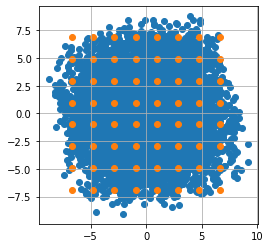

In [43]:
# run the k-means algorithm with scatterplot of the data over the estimated constellation points
K = 64
data_out = k_means(data,K,1000)
C_1 = data_out['C']
plt.scatter(data.real,data.imag)
plt.scatter(C_1.real,C_1.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.draw()

In [0]:
# init initial parameters for EM
pC_new = qam_cstll(K)
delta = C_1.real[0]/pC_new[0].real
noise = data_out['N'].real + 1j*data_out['N'].imag
px = data_out['px']
# start EM Algo
data_out_2 = em(data,C_1,px,noise,1000)








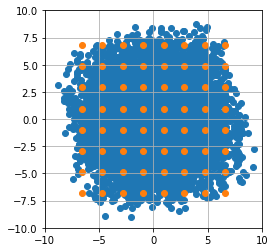

In [45]:
#data_out = k_means(data,36,1000)
C_2 = data_out_2['x']
plt.scatter(data.real,data.imag)
#plt.scatter(pC.real,pC.imag)
plt.scatter(C_2.real,C_2.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()
plt.draw()